## Some technical notes about audio parameters

- The sampled signal is obtained in the Linear Pulse Code Modulation (LPCM).
- The signal is stereo (`nchanells=2`), but it is only used the left-side signal.
- It is utilized 16 bits (2 bytes) per sample to encode the audio. The native data type of this data is `int16`, which is capable of storing a [range from](https://www.mathworks.com/help/matlab/ref/audioread.html) `-32768` up to `+32767`.
- The data type is converted to `float` because of the numeric precision and because the floating point in `Python` [is interpreted as](https://docs.python.org/3/library/stdtypes.html#numeric-types-int-float-complex) `double` in `C`, which is convenient.
- The float-converted raw data is then normalized by the maximum value reachable of the `int16` format, that is, `32768`. The resulting signal is the same achieved by the `audioread()` command of `matlab`.
- The original sampling rate is $44.1\;kHz$. But each recording is downsampled into two different signals, with a sampling rate of $F_s = 22.05\;kHz$.
- The audio dataset comprises five classes (the speeches "avançar", "recuar", "parar", "direita", and "esquerda"), each with 10 recordings, totalizing 50 files. With the downsampling, we have 20 recordings by class. Considering that the `.wav` file is stereo, that is, `nchannel=2`, the number of audio recordings by class is increased to 40. From each of these recordings, it is extracted a discrete-time signal, which is converted to a $N_s$-dimensional vector, being $N_s$ the number of samples of this signal.

## Some notes about the LPC (linear predictive coding) and the Yule-Walker algorithms

- The AR(p) model is implemented for `p=10`, `p=15`, and `p=20`.
- A single recording is divided into 31 frames without overlapping. The number of samples per frames, $N_f$, and the number of samples between each frame, $N_{gap}$, are given by
    $$ N_f = \frac{T_{sig}T_{f_{min}} F_s}{T_{min}} $$
    and
    $$ N_{gap} = \frac{T_{sig} F_s-31N_f}{30},$$
    where $T_{sig}$ is the signal duration, $T_{min}$ is the minimum signal duration of the dataset, and $T_{f_{min}} \triangleq 15\;ms $ is the minimum frame duration. All these variables are defined in seconds.
- The Yule-Walker equation is applied to each of the 31 frames produced from a single audio recording. The final vector is achieved by concatenating all the $31$ coefficients obtained by the Yule-Walker equation, it is given by
$$\mathbf{a}_{p} = \begin{bmatrix}
\mathbf{a}_{p,1}^\mathsf{T} & \mathbf{a}_{p,2}^\mathsf{T} & \cdots & \mathbf{a}_{p,31}^\mathsf{T}
\end{bmatrix}^\mathsf{T} \in \mathbb{R}^{31p},
$$
where $\mathbf{a}_{p,i} \in \mathbb{R}^p$ is the coefficient vector obtained form the $i$-th frame. This procedure is repeated for each of the four signals (channel a and b, samples even and odd) from a single audio recording, for each audio recording.
- For sake of clarity, it  is chosen the normalized (by its l2 norm) version of the autocorrelation function. It makes $r(\tau)$ invariant to the signal energy of the frame.
- It is chosen a split for 50%-50% for train and train dataset, as it is done in the article.

---

> 1. Carregar os diversos arquivos de áudio e realizar a subamostragem dos sinais de cada canal a fim
de gerar a base de dados de treino e teste.

### Initializing

In [25]:
# %reset -f
from numpy import inf, empty, concatenate, arange, inner, array, logical_and, where, identity, logspace, zeros, any
from numpy.linalg import norm, cond, matrix_rank as rank, inv
from numpy.random import normal
from numpy.fft import fft
import pandas as pd
from statsmodels.regression.linear_model import yule_walker
from statistics import mean, median
from scipy.io import wavfile, loadmat
from scipy.linalg import toeplitz
from scipy.signal import periodogram
from math import floor, log as ln, sqrt
from warnings import warn
from os import listdir
import itertools
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.family': 'DejaVu Sans', 'font.weight': 'normal', 'font.size': 22})

# number of files per commands
n_files = 10
# AR(p) model order -> p = 10, 15, 20
all_p = range(10,21,5)
# all commands
all_commands = ('avancar', 'esquerda', 'direita', 'parar', 'recuar')
# a dictionary that gather all signals and the coefficient estimation for each audio file
all_data = {f'{command}_{file_number}_p{p}_s{signal}': {'signal': empty(0), 'all_a': empty(0), 'all_a+noise_01': empty(0), 'all_a+noise_0625': empty(0), 'all_a_hat': empty(0), 'all_a_hat+noise_01': empty(0), 'all_a_hat+noise_0625': empty(0), 'all_a box-cox': empty(0), 'all_a+noise_01 box-cox': empty(0), 'all_a+noise_0625 box-cox': empty(0)} for p in all_p for command in all_commands for file_number in range(1,n_files+1) for signal in ('0a', '0b', '1a', '1b')}
a_plot, a_hat_plot = empty(0), empty(0)

def get_T_min(root_dir):
    T_min = inf
    for file_name in listdir(root_dir):
        F_s, s_n = wavfile.read(root_dir+file_name)
        # signal duration
        T_sig = s_n[:,0].size * (1/F_s)
        if T_sig < T_min:
            T_min = T_sig
    return T_min

def box_cox(x, gamma):
    assert 0 <= gamma and gamma < 1, 'the hyperparameter should be 0<=gamma<1'
    return ln(x) if gamma == 0 else (x**gamma -1)/gamma

# minimum audio duration of the dataset
T_min = get_T_min('./Audio_files_TCC_Jefferson/')
# minimum frame duration, 15ms (user-defined)
T_f_min = 15e-3

### LPC and Yule-Walker algorithm

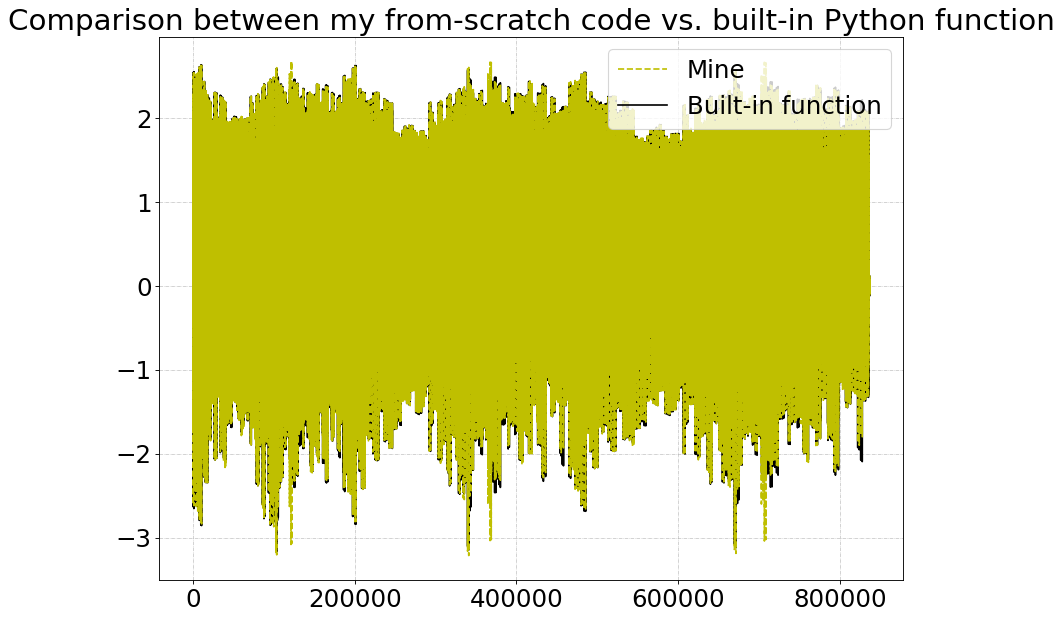

In [26]:
# %reset_selective -f all_a
for p in all_p:
    for command in all_commands:
        for file_number in range(1,n_files+1):
            file_name = f'./Audio_files_TCC_Jefferson/comando_{command}_{file_number:0>2d}.wav'
            # input audio vector, s_n -> [s[0], s[1], ..., s[N_s-1]]
            F_s, s_n = wavfile.read(file_name)
            # Number of samples
            N_s = s_n[:,0].size
            # signal duration
            T_sig = N_s/F_s
            # convert from int16 to float type and normalize it to range from -1 up to 1 (as matlab does)
            s_n = s_n.astype(float)/32768
            # downsampling: generate s0_n (even samples) and s1_n (odd samples) from s_n
            s0_n, s1_n = s_n[range(0,N_s,2),:], s_n[range(1,N_s,2),:]
            N_s //= 2
            F_s //= 2
            # number of samples per frame
            N_f = floor(T_sig*T_f_min*F_s/T_min)
            # number of samples between each frame (gap)
            N_gap = floor((N_s - 31*N_f)/30)
            # get channel a and chanell b
            s0a_n, s0b_n, s1a_n, s1b_n = s0_n[:,0], s0_n[:,1], s1_n[:,0], s1_n[:,1]

            # for each of the 4 signals from a single recording: channel a and b, samples even and odd
            for s, sig_id in zip((s0a_n, s0b_n, s1a_n, s1b_n), ('0a', '0b', '1a', '1b')):
                # save signal - no noise
                all_data[f'{command}_{file_number}_p{p}_s{sig_id}']['signal'] = s
                # set and save the one-hot-encoding
                all_data[f'{command}_{file_number}_p{p}_s{sig_id}']['d'] = array([command==c for c in all_commands])
                # generate and save signal + w ~ N(0,sd^2)
                s_01 = s + sqrt(.01)*normal(size=s.shape)
                s_0625 = s + sqrt(.0625)*normal(size=s.shape)
                all_data[f'{command}_{file_number}_p{p}_s{sig_id}']['signal+noise_01'] = s_01
                all_data[f'{command}_{file_number}_p{p}_s{sig_id}']['signal+noise_0625'] = s_0625
                # for each noisy signal
                for s_noise, noise_id in zip((s, s_01, s_0625), ('', '+noise_01', '+noise_0625')):
                    # for each frame
                    for i, n in enumerate(range(0, N_s+1, N_f)):
                        # ensure that it is get only 31 frames
                        if i == 31:
                            break
                        # s_n0 -> [s[n0], s[n0+1], ..., s[n0+N_f-1]], being n0\in\mathbb{N}
                        s_n0 = s_noise[n+i*N_gap:n+i*N_gap+N_f]
                        # compute the autocorrelation function (normalized version), r_k -> r[k] -> [r[0], r[1], ..., r[p]]
                        r_k = empty(p+1)
                        for k in range(p+1):
                            r_k[k] = inner(s_n0[:N_f-k], s_n0[k:N_f])/norm(s_n0)
                        # autocorrelation matrix
                        # r_k[:p] -> [r[0], r[1], ..., r[p-1]]
                        R = toeplitz(r_k[:p])
                        # autocorrelation vector
                        # r -> [r[1], r[2], ..., r[p]]
                        r = r_k[1:]
                        if rank(R) == R.shape[0]:
                            # Yule-Walker equation
                            a = inv(R) @ r
                            # built-in function for comparison purpose
                            a_hat, _ = yule_walker(s_n0, order=p, method='mle')
                            # save a
                            all_data[f'{command}_{file_number}_p{p}_s{sig_id}'][f'all_a{noise_id}'] = concatenate((all_data[f'{command}_{file_number}_p{p}_s{sig_id}'][f'all_a{noise_id}'], a))
                            a_plot = concatenate((a_plot, a))
                            # save a_hat
                            all_data[f'{command}_{file_number}_p{p}_s{sig_id}'][f'all_a_hat{noise_id}'] = concatenate((all_data[f'{command}_{file_number}_p{p}_s{sig_id}'][f'all_a_hat{noise_id}'], a_hat))
                            a_hat_plot = concatenate((a_hat_plot, a_hat))
                        else:
                            warn(f'The autocorrelation matrix of the audio {file_name.split("/")[0]} is rank-deficient, skip over to the next audio recording.')



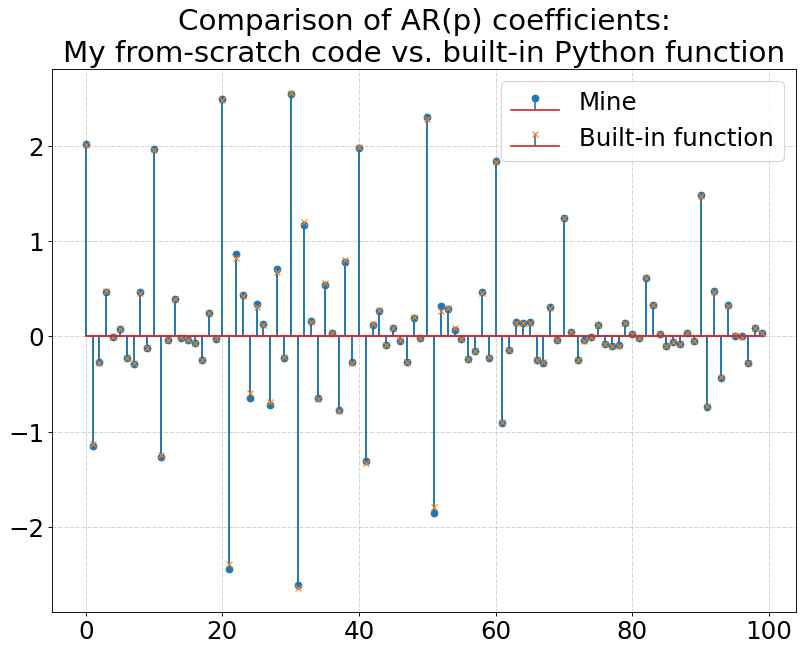

In [49]:

fig = plt.figure(figsize=(12, 9), dpi=80)
ax = fig.gca()
ax.set_axisbelow(True)
ax.stem(a_plot[:100], markerfmt='o', label='Mine')
ax.stem(a_hat_plot[:100], markerfmt='x', label='Built-in function')
plt.legend(loc="upper right")
plt.title('Comparison of AR(p) coefficients:\nMy from-scratch code vs. built-in Python function')
plt.grid(True, linestyle='-.', linewidth=.5)
plt.show()

### Determine each voice signal using the PSD segmentation method estimated by the periodogram

In [27]:
# my periodogram estimate function - FROM SCRATCH
def my_periodogram(g, Fs):
    N = g.size
    # Nyquist theorem
    W = Fs/2
    # FFT
    G = fft(g)
    # two-sided periodogram estimate
    p = abs(G)**2 / (N*Fs)
    # transform it into one-sided
    p = p[0:1+N//2]
    p[1:-1] *= 2
    # all frequencies
    all_f = arange(0,W+Fs/N,Fs/N)[:p.size]
    
    return p, all_f

# lower and upper bound
all_lb = (0, 100, 200, 360, 500, 700, 850, 1000, 1200, 1320, 1500, 2200, 2700)
all_ub = all_lb[1:] + (3700,)

for key, data in all_data.items():
    # As the 4 signals are identical for p \in {10, 15, 20}, it is not necessary to compute x for different values of p
    if 'p10' not in key:
        continue
    for noise_id in '', '+noise_01', '+noise_0625':
        s = data[f'signal{noise_id}']
        p, all_f = my_periodogram(s, F_s)
        _, p_builtin = periodogram(s, fs=F_s)
        # for each lower and upper bound interval, get the maximum value
        psd_sampled = array([max(p[logical_and(all_f>=lb, all_f<=ub)]) for lb, ub in zip(all_lb, all_ub)])
        # save the attribute vector and all PSD
        all_data[key][f'psd{noise_id} sampled'] = psd_sampled
        # save the attribute vector and all PSD with box-cox
        all_data[key][f'psd{noise_id} sampled box-cox'] = box_cox(psd_sampled, 0.1)
        # save PSD from my periodogram estimate
        all_data[key][f'psd{noise_id}'] = p
        # save PSD from my periodogram estimate - built-in function
        all_data[key][f'psd{noise_id} built-in'] = p_builtin

### The Linear Least-Squares (LS) classifier

In [28]:
class LS_Classifier():
    def __init__(self):
        self.n_errors = []
        self.confusion_matrix_best = zeros((5, 5))
        self.confusion_matrix_worst = zeros((5, 5))
    
    # training
    def train(self, X, D):
        # Tikhonov regularization
        for lambda_ in logspace(0,10,base=2):
            W_hat = D @ X.T @ inv(X @ X.T + (lambda_-1)*identity(X.shape[0]))
            # if W_hat is ill-conditioned, regularize it
            if cond(X @ X.T + (lambda_-1)*identity(X.shape[0])) <= 5e3:
                break
        self.W_hat = W_hat
    
    # testing
    def test(self, X, D):
        n_errors = 0
        self.N_test = X.shape[1] # number of columns
        confusion_matrix = zeros((5,5))
        # testing phase
        for x, d in zip(X.T, D.T): # for each column
            d_hat = self.W_hat @ x
            label = where(d == max(d))[0][0]
            guessed = where(d_hat == max(d_hat))[0][0]
            if label != guessed:
                n_errors += 1
            confusion_matrix[guessed][label] += 1
        
        # saving phase
        if self.n_errors: # if self.n_errors is not empty
            if n_errors > max(self.n_errors): # this is the worst test dataset?
                self.confusion_matrix_worst = confusion_matrix
            elif n_errors < min(self.n_errors): # this is the best test dataset?
                self.confusion_matrix_best = confusion_matrix
        else:
            self.confusion_matrix_worst = confusion_matrix
            self.confusion_matrix_best = confusion_matrix
        # save n_errors
        self.n_errors.append(n_errors)
    
    # mean accuracy in %
    def get_mean(self):
        return (self.N_test - mean(self.n_errors))*100 / self.N_test
    # median accuracy in %
    def get_median(self):
        return (self.N_test - median(self.n_errors))*100 / self.N_test
    # max accuracy in %
    def get_max(self):
        return (self.N_test - min(self.n_errors))*100 / self.N_test
    # min accuracy in %
    def get_min(self):
        return (self.N_test - max(self.n_errors))*100 / self.N_test
    
    def get_confusion_matrix_worst(self):
        return self.confusion_matrix_worst

    def get_confusion_matrix_best(self):
        return self.confusion_matrix_best

#### K-fold cross validation: LS classifier + LPC

In [29]:
# LPC attribute vector size for LPC algorithm -> 31 frames x 10 attributes per frame
P_LPC = 310
n_folds = 10
# columns_per_fold = X_LPC.shape[1]//10
kfold_iterator = itertools.combinations(range(1,n_folds+1), n_folds//2)
ls_classifier = LS_Classifier()

for train_set in kfold_iterator:
    # generate train dataset
    X_train, D_train = empty((P_LPC, 0)), empty((5, 0))
    all_data_train = {key:value for key, value in all_data.items() if 'p10' in key and any([key.split('_')[1] == str(e) for e in train_set])}
    for data in all_data_train.values():
        X_train = concatenate((X_train, data['all_a'][:,None]), axis=1)
        D_train = concatenate((D_train, data['d'][:,None]), axis=1)
    # generate test dataset
    X_test, D_test = empty((P_LPC, 0)), empty((5, 0))
    test_set = list(range(1,11))
    for e in train_set:
        test_set.remove(e)
    all_data_test = {key:value for key, value in all_data.items() if 'p10' in key and any([key.split('_')[1] == str(e) for e in test_set])}
    for data in all_data_test.values():
        X_test = concatenate((X_test, data['all_a'][:,None]), axis=1)
        D_test = concatenate((D_test, data['d'][:,None]), axis=1)
    ls_classifier.train(X_train, D_train)
    ls_classifier.test(X_test, D_test)

LSC_LPC = {'mean': ls_classifier.get_mean(), 'median': ls_classifier.get_median(), 'max': ls_classifier.get_max(), 'min': ls_classifier.get_min(), 'best confusion matrix': ls_classifier.get_confusion_matrix_best(), 'worst confision matrix': ls_classifier.get_confusion_matrix_worst()}

#### K-fold cross validation: LS classifier + PSD

In [30]:
# PSD attribute vector size -> 13 frames of the PSD
P_PSD = 13
# columns_per_fold = X_LPC.shape[1]//10
kfold_iterator = itertools.combinations(range(1,n_folds+1), n_folds//2)
ls_classifier = LS_Classifier()

for train_set in kfold_iterator:
    # generate train dataset
    X_train, D_train = empty((P_PSD, 0)), empty((5, 0))
    all_data_train = {key:value for key, value in all_data.items() if 'p10' in key and any([key.split('_')[1] == str(e) for e in train_set])}
    for data in all_data_train.values():
        X_train = concatenate((X_train, data['psd sampled'][:,None]), axis=1)
        D_train = concatenate((D_train, data['d'][:,None]), axis=1)
    # generate test dataset
    X_test, D_test = empty((P_PSD, 0)), empty((5, 0))
    test_set = list(range(1,11))
    for e in train_set:
        test_set.remove(e)
    all_data_test = {key:value for key, value in all_data.items() if 'p10' in key and any([key.split('_')[1] == str(e) for e in test_set])}
    for data in all_data_test.values():
        X_test = concatenate((X_test, data['psd sampled'][:,None]), axis=1)
        D_test = concatenate((D_test, data['d'][:,None]), axis=1)
    ls_classifier.train(X_train, D_train)
    ls_classifier.test(X_test, D_test)

LSC_PSD = {'mean': ls_classifier.get_mean(), 'median': ls_classifier.get_median(), 'max': ls_classifier.get_max(), 'min': ls_classifier.get_min(), 'best confusion matrix': ls_classifier.get_confusion_matrix_best(), 'worst confision matrix': ls_classifier.get_confusion_matrix_worst()}

### k-fold cross validation: LS classifier + PSD + Box-Cox

In [31]:
# columns_per_fold = X_LPC.shape[1]//10
kfold_iterator = itertools.combinations(range(1,n_folds+1), n_folds//2)
ls_classifier = LS_Classifier()

for train_set in kfold_iterator:
    # generate train dataset
    X_train, D_train = empty((P_PSD, 0)), empty((5, 0))
    all_data_train = {key:value for key, value in all_data.items() if 'p10' in key and any([key.split('_')[1] == str(e) for e in train_set])}
    for data in all_data_train.values():
        X_train = concatenate((X_train, data['psd sampled box-cox'][:,None]), axis=1)
        D_train = concatenate((D_train, data['d'][:,None]), axis=1)
    # generate test dataset
    X_test, D_test = empty((P_PSD, 0)), empty((5, 0))
    test_set = list(range(1,11))
    for e in train_set:
        test_set.remove(e)
    all_data_test = {key:value for key, value in all_data.items() if 'p10' in key and any([key.split('_')[1] == str(e) for e in test_set])}
    for data in all_data_test.values():
        X_test = concatenate((X_test, data['psd sampled box-cox'][:,None]), axis=1)
        D_test = concatenate((D_test, data['d'][:,None]), axis=1)
    ls_classifier.train(X_train, D_train)
    ls_classifier.test(X_test, D_test)

LSC_PSD_BC = {'mean': ls_classifier.get_mean(), 'median': ls_classifier.get_median(), 'max': ls_classifier.get_max(), 'min': ls_classifier.get_min(), 'best confusion matrix': ls_classifier.get_confusion_matrix_best(), 'worst confision matrix': ls_classifier.get_confusion_matrix_worst()}

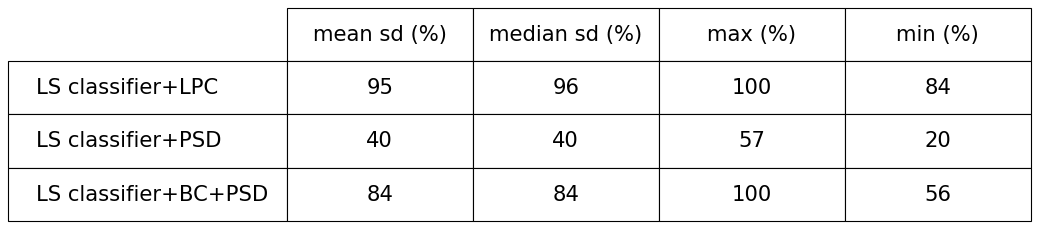

In [32]:
fig = plt.figure(figsize=(12, 3), dpi=80)
ax = fig.gca()
# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
col_labels = ['mean sd (%)', 'median sd (%)', 'max (%)', 'min (%)']
row_labels = ['LS classifier+LPC', 'LS classifier+PSD', 'LS classifier+BC+PSD']
cell_tex = [[f'{x[value]:.0f}' for value in ('mean', 'median', 'max', 'min')] for x in (LSC_LPC, LSC_PSD, LSC_PSD_BC)]

table_ = ax.table(cellText=cell_tex, colLabels=col_labels, loc='center', cellLoc='center', rowLabels=row_labels)
table_.scale(1, 4)
plt.show()

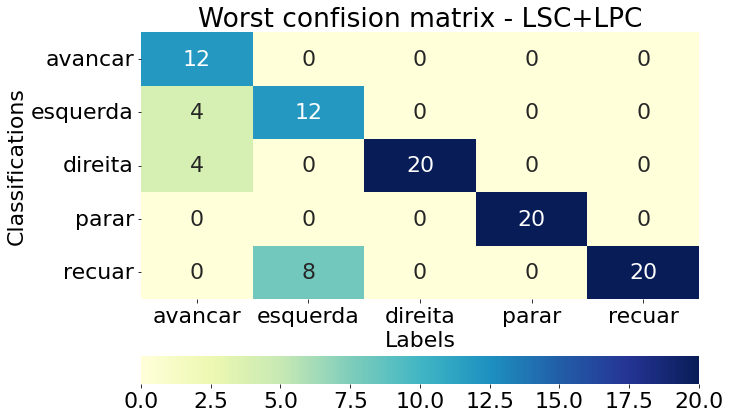

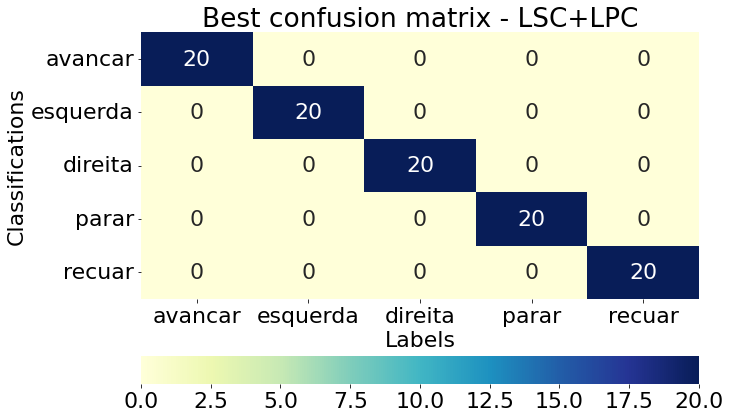

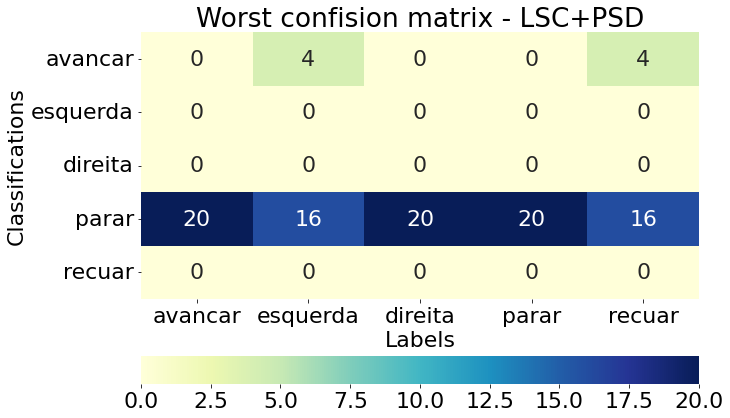

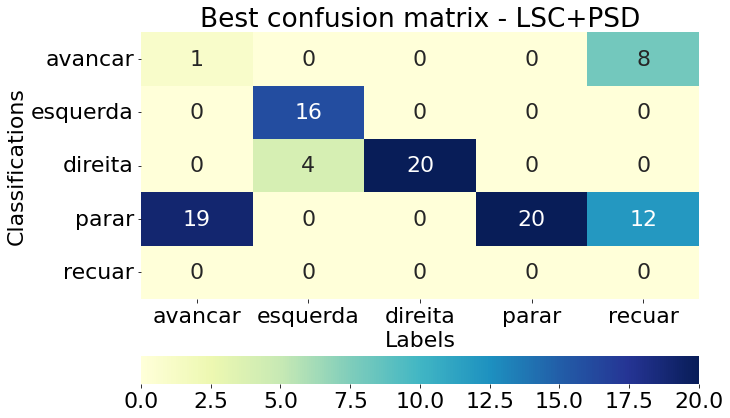

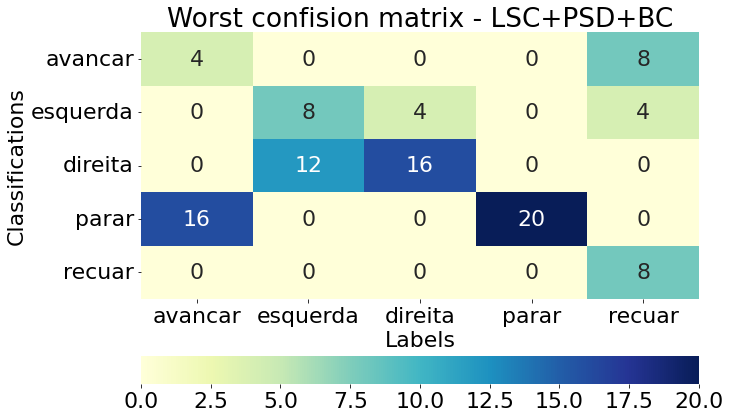

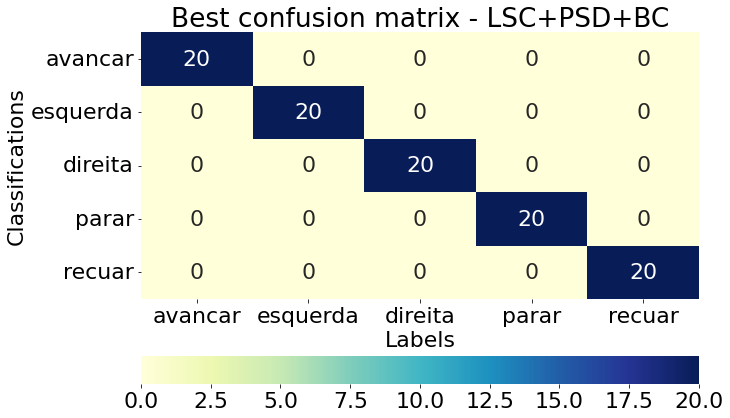

In [33]:
for method, method_name in zip((LSC_LPC, LSC_PSD, LSC_PSD_BC), ('LSC+LPC', 'LSC+PSD', 'LSC+PSD+BC')):
    for conf_mat in 'worst confision matrix', 'best confusion matrix':
        df_conf_mat = pd.DataFrame(method[conf_mat], index=all_commands, columns=all_commands)
        fig = plt.figure(figsize = (10,7))
        ax = fig.gca()
        plt.title(f'{conf_mat.capitalize()} - {method_name}')
        ax = sns.heatmap(df_conf_mat, annot=True, cmap="YlGnBu", cbar_kws={"orientation": "horizontal"})
        ax.set_xlabel('Labels')
        ax.set_ylabel('Classifications')

## Analysis with noise ~ $N(0, 0.625)$

#### K-fold cross validation: LS classifier + LPC

In [34]:
# LPC attribute vector size for LPC algorithm -> 31 frames x 10 attributes per frame
P_LPC = 310
n_folds = 10
# columns_per_fold = X_LPC.shape[1]//10
kfold_iterator = itertools.combinations(range(1,n_folds+1), n_folds//2)
ls_classifier = LS_Classifier()

for train_set in kfold_iterator:
    # generate train dataset
    X_train, D_train = empty((P_LPC, 0)), empty((5, 0))
    all_data_train = {key:value for key, value in all_data.items() if 'p10' in key and any([key.split('_')[1] == str(e) for e in train_set])}
    for data in all_data_train.values():
        X_train = concatenate((X_train, data['all_a+noise_0625'][:,None]), axis=1)
        D_train = concatenate((D_train, data['d'][:,None]), axis=1)
    # generate test dataset
    X_test, D_test = empty((P_LPC, 0)), empty((5, 0))
    test_set = list(range(1,11))
    for e in train_set:
        test_set.remove(e)
    all_data_test = {key:value for key, value in all_data.items() if 'p10' in key and any([key.split('_')[1] == str(e) for e in test_set])}
    for data in all_data_test.values():
        X_test = concatenate((X_test, data['all_a+noise_0625'][:,None]), axis=1)
        D_test = concatenate((D_test, data['d'][:,None]), axis=1)
    ls_classifier.train(X_train, D_train)
    ls_classifier.test(X_test, D_test)

LSC_LPC = {'mean': ls_classifier.get_mean(), 'median': ls_classifier.get_median(), 'max': ls_classifier.get_max(), 'min': ls_classifier.get_min(), 'best confusion matrix': ls_classifier.get_confusion_matrix_best(), 'worst confision matrix': ls_classifier.get_confusion_matrix_worst()}

#### K-fold cross validation: LS classifier + PSD

In [35]:
# PSD attribute vector size -> 13 frames of the PSD
P_PSD = 13
# columns_per_fold = X_LPC.shape[1]//10
kfold_iterator = itertools.combinations(range(1,n_folds+1), n_folds//2)
ls_classifier = LS_Classifier()

for train_set in kfold_iterator:
    # generate train dataset
    X_train, D_train = empty((P_PSD, 0)), empty((5, 0))
    all_data_train = {key:value for key, value in all_data.items() if 'p10' in key and any([key.split('_')[1] == str(e) for e in train_set])}
    for data in all_data_train.values():
        X_train = concatenate((X_train, data['psd+noise_0625 sampled'][:,None]), axis=1)
        D_train = concatenate((D_train, data['d'][:,None]), axis=1)
    # generate test dataset
    X_test, D_test = empty((P_PSD, 0)), empty((5, 0))
    test_set = list(range(1,11))
    for e in train_set:
        test_set.remove(e)
    all_data_test = {key:value for key, value in all_data.items() if 'p10' in key and any([key.split('_')[1] == str(e) for e in test_set])}
    for data in all_data_test.values():
        X_test = concatenate((X_test, data['psd+noise_0625 sampled'][:,None]), axis=1)
        D_test = concatenate((D_test, data['d'][:,None]), axis=1)
    ls_classifier.train(X_train, D_train)
    ls_classifier.test(X_test, D_test)

LSC_PSD = {'mean': ls_classifier.get_mean(), 'median': ls_classifier.get_median(), 'max': ls_classifier.get_max(), 'min': ls_classifier.get_min(), 'best confusion matrix': ls_classifier.get_confusion_matrix_best(), 'worst confision matrix': ls_classifier.get_confusion_matrix_worst()}

### k-fold cross validation: LS classifier + PSD + Box-Cox

In [36]:
# columns_per_fold = X_LPC.shape[1]//10
kfold_iterator = itertools.combinations(range(1,n_folds+1), n_folds//2)
ls_classifier = LS_Classifier()

for train_set in kfold_iterator:
    # generate train dataset
    X_train, D_train = empty((P_PSD, 0)), empty((5, 0))
    all_data_train = {key:value for key, value in all_data.items() if 'p10' in key and any([key.split('_')[1] == str(e) for e in train_set])}
    for data in all_data_train.values():
        X_train = concatenate((X_train, data['psd+noise_0625 sampled box-cox'][:,None]), axis=1)
        D_train = concatenate((D_train, data['d'][:,None]), axis=1)
    # generate test dataset
    X_test, D_test = empty((P_PSD, 0)), empty((5, 0))
    test_set = list(range(1,11))
    for e in train_set:
        test_set.remove(e)
    all_data_test = {key:value for key, value in all_data.items() if 'p10' in key and any([key.split('_')[1] == str(e) for e in test_set])}
    for data in all_data_test.values():
        X_test = concatenate((X_test, data['psd+noise_0625 sampled box-cox'][:,None]), axis=1)
        D_test = concatenate((D_test, data['d'][:,None]), axis=1)
    ls_classifier.train(X_train, D_train)
    ls_classifier.test(X_test, D_test)

LSC_PSD_BC = {'mean': ls_classifier.get_mean(), 'median': ls_classifier.get_median(), 'max': ls_classifier.get_max(), 'min': ls_classifier.get_min(), 'best confusion matrix': ls_classifier.get_confusion_matrix_best(), 'worst confision matrix': ls_classifier.get_confusion_matrix_worst()}

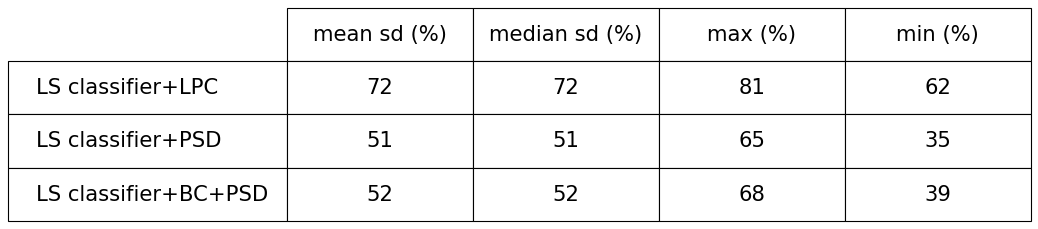

In [37]:
fig = plt.figure(figsize=(12, 3), dpi=80)
ax = fig.gca()
# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
col_labels = ['mean sd (%)', 'median sd (%)', 'max (%)', 'min (%)']
row_labels = ['LS classifier+LPC', 'LS classifier+PSD', 'LS classifier+BC+PSD']
cell_tex = [[f'{x[value]:.0f}' for value in ('mean', 'median', 'max', 'min')] for x in (LSC_LPC, LSC_PSD, LSC_PSD_BC)]

table_ = ax.table(cellText=cell_tex, colLabels=col_labels, loc='center', cellLoc='center', rowLabels=row_labels)
table_.scale(1, 4)
plt.show()

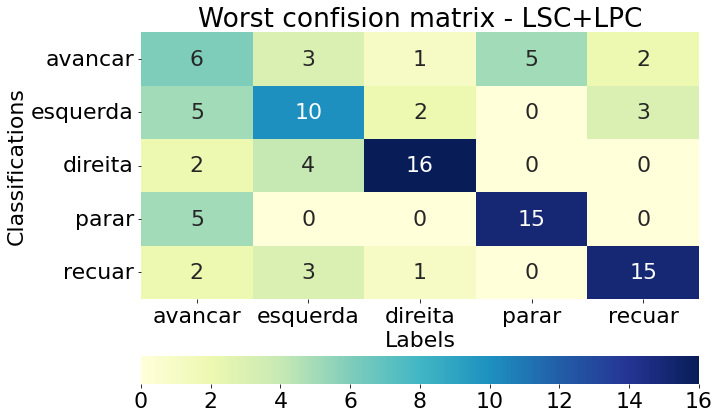

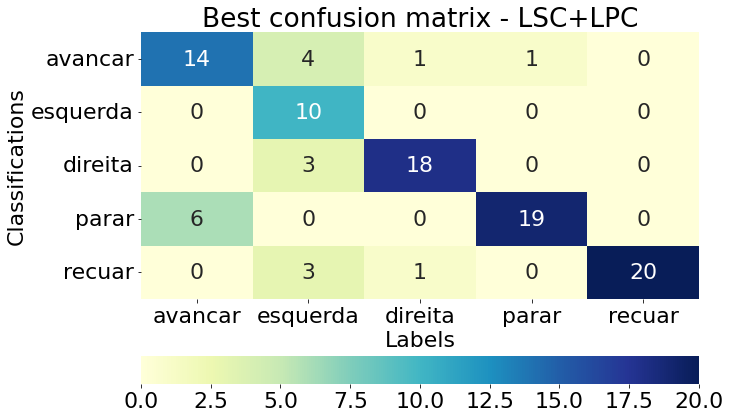

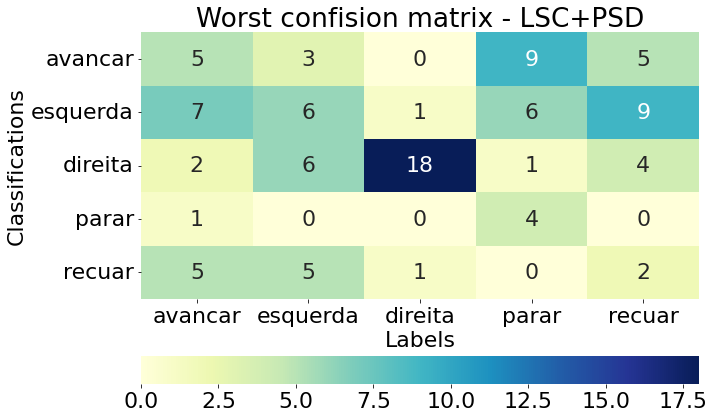

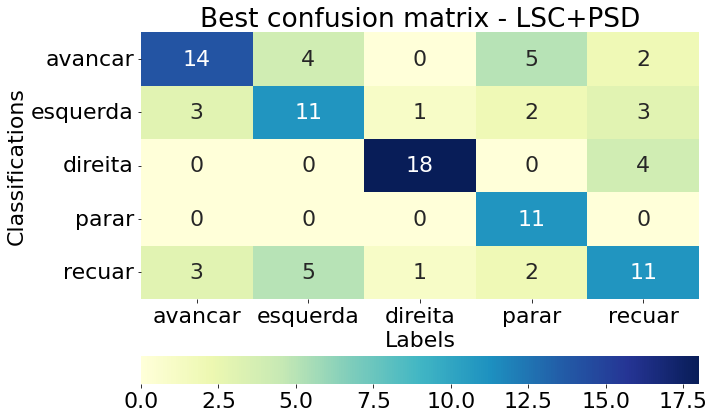

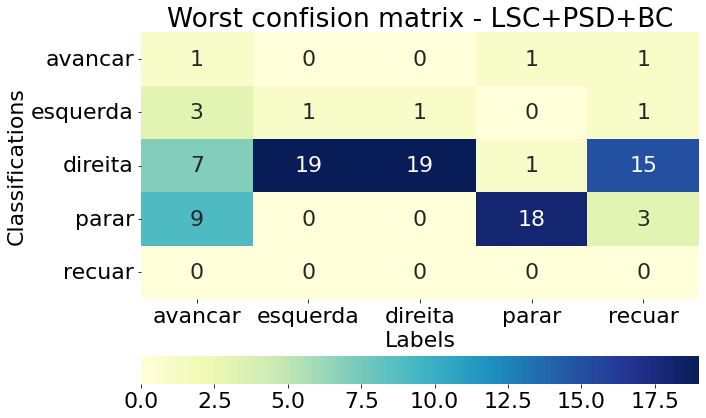

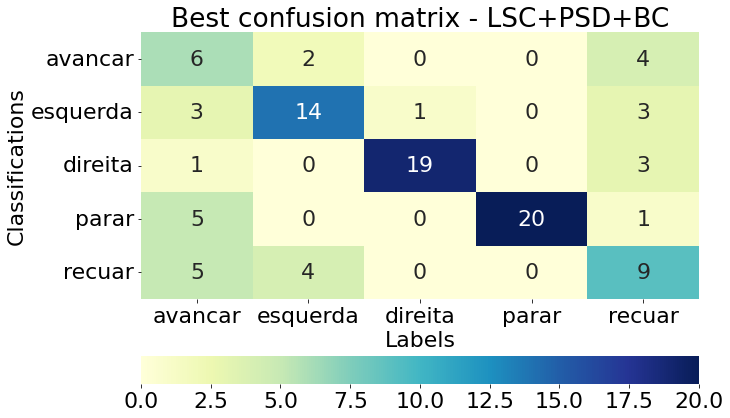

In [38]:
for method, method_name in zip((LSC_LPC, LSC_PSD, LSC_PSD_BC), ('LSC+LPC', 'LSC+PSD', 'LSC+PSD+BC')):
    for conf_mat in 'worst confision matrix', 'best confusion matrix':
        df_conf_mat = pd.DataFrame(method[conf_mat], index=all_commands, columns=all_commands)
        fig = plt.figure(figsize = (10,7))
        ax = fig.gca()
        plt.title(f'{conf_mat.capitalize()} - {method_name}')
        ax = sns.heatmap(df_conf_mat, annot=True, cmap="YlGnBu", cbar_kws={"orientation": "horizontal"})
        ax.set_xlabel('Labels')
        ax.set_ylabel('Classifications')